In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [20]:

%pdb

Automatic pdb calling has been turned OFF


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
#from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [129]:
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size

def retrain_model(mean, var, zmean, zvar, tau, temp, mixtures, model_name, mode, loss_type = 'MSESNT', scaling = False, model_save_dir = "",  fn="", dset="mnist"):
    ab = get_ab(mean, var)
    zab = get_ab(zmean, zvar)

    model_file = 'mnist_{}_{}_{}'.format("LeNet_300_100", 100, "full")
    model = torch.load(model_load_dir + model_file + '.m').cuda()

    train_input = train_data(fetch = "data")[0:2000].cuda()
    if (mode == "sws"):
        output = train_data(fetch = "labels")[0:2000].cuda()
        retraining_epochs = 250
    if (mode == "kd"):
        output = model(Variable(train_input))
        output = (nn.Softmax(dim=1)(output/temp)).data
        retraining_epochs = 250
    if (mode == "synth"):
        mean=train_input.mean(dim=0).cpu().numpy()
        std=train_input.std(dim=0).cpu().numpy()
        new_data = np.concatenate([[np.random.normal(mean, std) for x in range(10000)]], axis=1)
        train_data_exp = torch.Tensor(new_data).clamp(0,1).cuda()
        #train_input_exp = torch.cat([train_input + (torch.FloatTensor(2000, 28, 28).normal_(0, 0.2)).cuda() for x in range(5)]).clamp(0, 1)
        output = model(Variable(train_input_exp))
        output = (nn.Softmax(dim=1)(output/temp)).data
        train_input = train_input_exp
        retraining_epochs = 250

    dataset = torch.utils.data.TensorDataset(train_input, output)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), s, mode) + fn
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, zero_ab = zab, ab = ab, scaling = scaling)
    gmp.print_batch = False

    mlr = 0.5e-4 if scaling else 0.5e-4

    optimizable_params = [
        {'params': model.parameters(), 'lr': 5e-4},
        {'params': [gmp.means], 'lr': mlr},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}]
    if (scaling):
        optimizable_params = optimizable_params + [{'params': gmp.scale, 'lr': 1e-6}]

    opt = torch.optim.Adam(optimizable_params)#log precisions and mixing proportions

    res_stats = plot_data(init_model = model, gmp = gmp, mode = 'retrain', data_size = "full", loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    s_hist = []
    a_hist = []
    for epoch in range(retraining_epochs):
        ### [ACT DISABLE LR]
        if(scaling and epoch == 0):
            opt.param_groups[3]['lr'] = 0
            print ("Scaling Disabled - Epoch {}".format(epoch))
        model, loss = retrain_sws_epoch(model, gmp, opt, loader, tau, temp, loss_type)
        res_stats.data_epoch(epoch + 1, model, gmp)


        if (trueAfterN(epoch, 10)):
            #test_acc = test_accuracy(test_data_full, test_labels_full, model)
            nm = sws_prune_copy(model, gmp)
            s = get_sparsity(nm)
            a = test_accuracy(test_data_full, test_labels_full, nm)[0]

            print('Epoch: {}. Test Accuracy: {:.2f}, Prune Accuracy: {:.2f}, Sparsity: {:.2f}'.format(epoch+1, res_stats.test_accuracy[-1], a, s))
            #show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)###
        nm = sws_prune_copy(model, gmp)
        s = get_sparsity(nm)
        a = test_accuracy(test_data_full, test_labels_full, nm)[0]
        s_hist.append(s)
        a_hist.append(a)

    res = res_stats.gen_dict()

    model_prune = sws_prune_copy(model, gmp)

    res_stats.data_prune(model_prune)
    res = res_stats.gen_dict()
    res['test_prune_acc'] = a_hist
    res['test_prune_sp'] = s_hist
    cm = compressed_model(model_prune.state_dict(), [gmp])
    res['cm'] = cm.get_cr_list()

    print('Retrain Test: {:.2f}, Prune Test: {:.2f}, Prune Sparsity: {:.2f}'.format(res['test_acc'][-1], res['prune_acc']['test'],res['sparsity']))

    if(model_save_dir!=""):
        torch.save(model, model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(res, f)

    return model, gmp, res

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.18, Prune Accuracy: 97.80, Sparsity: 54.30
Epoch: 20. Test Accuracy: 97.72, Prune Accuracy: 96.37, Sparsity: 72.96
Epoch: 30. Test Accuracy: 96.93, Prune Accuracy: 92.99, Sparsity: 82.70
Epoch: 40. Test Accuracy: 96.01, Prune Accuracy: 77.89, Sparsity: 87.36
Epoch: 50. Test Accuracy: 94.94, Prune Accuracy: 67.40, Sparsity: 89.23
Epoch: 60. Test Accuracy: 94.16, Prune Accuracy: 65.56, Sparsity: 91.05
Epoch: 70. Test Accuracy: 94.18, Prune Accuracy: 61.33, Sparsity: 92.44
Epoch: 80. Test Accuracy: 93.40, Prune Accuracy: 55.10, Sparsity: 94.21
Epoch: 90. Test Accuracy: 93.49, Prune Accuracy: 46.23, Sparsity: 95.98
Epoch: 100. Test Accuracy: 92.83, Prune Accuracy: 42.15, Sparsity: 97.50
Epoch: 110. Test Accuracy: 92.18, Prune Accuracy: 25.08, Sparsity: 98.43
Epoch: 120. Test Accuracy: 92.04, Prune Accuracy: 28.78, Sparsity: 98.92
Epoch: 130. Test Accuracy: 91.84, Prune Accuracy

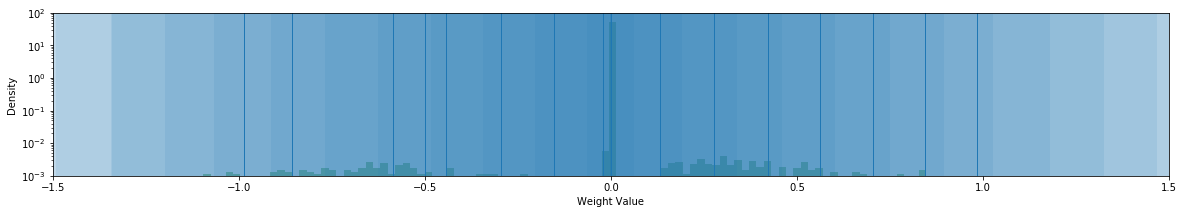

In [130]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 5e-6, int(0), 16, "LeNet_300_100", "sws", 'CESNT', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25, Prune Accuracy: 98.08, Sparsity: 49.13
Epoch: 20. Test Accuracy: 97.69, Prune Accuracy: 97.37, Sparsity: 61.89
Epoch: 30. Test Accuracy: 96.88, Prune Accuracy: 96.51, Sparsity: 68.68
Epoch: 40. Test Accuracy: 96.02, Prune Accuracy: 95.74, Sparsity: 72.40
Epoch: 50. Test Accuracy: 95.51, Prune Accuracy: 94.44, Sparsity: 75.37
Epoch: 60. Test Accuracy: 94.72, Prune Accuracy: 90.13, Sparsity: 77.90
Epoch: 70. Test Accuracy: 94.27, Prune Accuracy: 74.36, Sparsity: 88.27
Epoch: 80. Test Accuracy: 94.00, Prune Accuracy: 66.03, Sparsity: 93.88
Epoch: 90. Test Accuracy: 93.76, Prune Accuracy: 60.43, Sparsity: 95.93
Epoch: 100. Test Accuracy: 93.55, Prune Accuracy: 54.46, Sparsity: 97.35
Epoch: 110. Test Accuracy: 93.18, Prune Accuracy: 51.42, Sparsity: 98.38
Epoch: 120. Test Accuracy: 92.88, Prune Accuracy: 50.55, Sparsity: 99.07
Epoch: 130. Test Accuracy: 92.55, Prune Accur

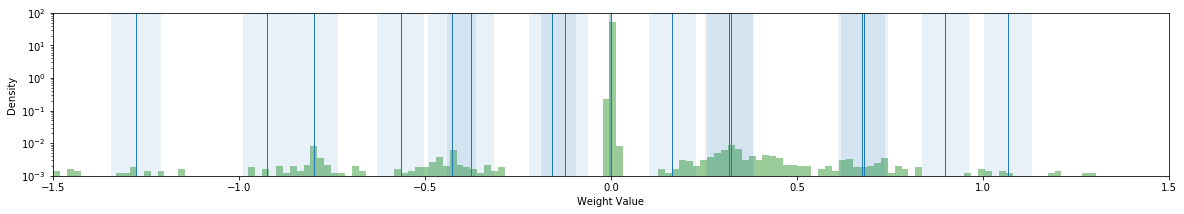

In [131]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "kd", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.70, Prune Accuracy: 96.78, Sparsity: 58.55
Epoch: 20. Test Accuracy: 94.46, Prune Accuracy: 69.77, Sparsity: 96.34
Epoch: 30. Test Accuracy: 90.93, Prune Accuracy: 77.64, Sparsity: 90.71
Epoch: 40. Test Accuracy: 89.43, Prune Accuracy: 84.97, Sparsity: 99.32
Epoch: 50. Test Accuracy: 89.16, Prune Accuracy: 86.62, Sparsity: 99.47
Epoch: 60. Test Accuracy: 89.90, Prune Accuracy: 87.67, Sparsity: 99.47
Epoch: 70. Test Accuracy: 89.55, Prune Accuracy: 87.45, Sparsity: 99.47
Epoch: 80. Test Accuracy: 89.79, Prune Accuracy: 87.59, Sparsity: 99.42
Epoch: 90. Test Accuracy: 89.64, Prune Accuracy: 88.52, Sparsity: 97.91
Epoch: 100. Test Accuracy: 90.04, Prune Accuracy: 88.64, Sparsity: 99.26
Epoch: 110. Test Accuracy: 89.89, Prune Accuracy: 87.91, Sparsity: 99.41
Epoch: 120. Test Accuracy: 89.72, Prune Accuracy: 88.58, Sparsity: 99.41
Epoch: 130. Test Accuracy: 89.83, Prune Accur

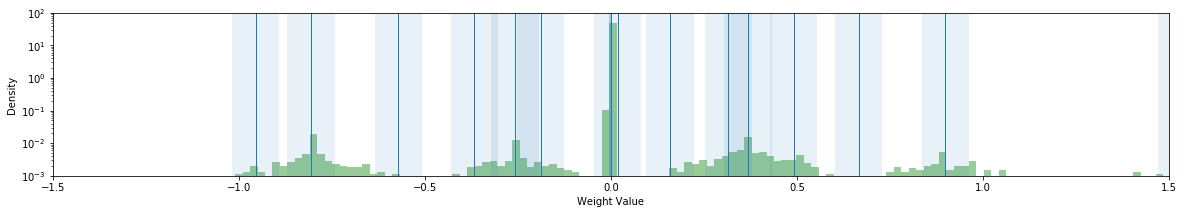

In [132]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))